<a href="https://colab.research.google.com/github/delibae/health_care_pr/blob/minjong/project_2/%EA%B9%80%EB%AF%BC%EC%A2%85/Pill_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 경구 약제 이미지 분류
### 단일 경구약제 1000종 데이터
> 전체 데이터가 3.65TB이기 떄문에 노트북이나 드라이브 용량 사정상 전체 데이터가 불가능 했다.  
> 그래서 데이터 다운로드시 각 이미지를 분리해서 다운 받을 수 있게 되어있어 용량을 확인해보았다. 단일 경구약제 1000종 데이터중 훈련데이터에서 가장 작은 용량이 13GB였는데 이중에서 라벨링 데이터(json)에 있는 이미지 파일만 가져와서 사용을 하였다(1300장 가량)  
> 이 데이터 내에서 train, val, test를 나누어서 사용해보고자 한다.


In [ ]:
# matplotlib 한글
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/sw_single_project/json/K-038929_json

In [ ]:
cd /content/drive/MyDrive/sw_single_project/pill_imgs/res

In [3]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import json
import random
from glob import glob
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 데이터 확인
df = pd.DataFrame()
for i, name in enumerate(glob('*.json')):
  with open(name) as f:
    data = json.load(f)
    json_test = pd.json_normalize(data["images"])
    df = df.append(json_test,ignore_index=True)
df

In [5]:
# 필요 없는 데이터 처치 
"""  
{
			"file_name": "K-039036_0_1_1_2_90_160_200.png",  
			"width": 976, 
			"height": 1280,
			"imgfile": "K-039036_0_1_1_2_90_160_200.png", 
			"drug_N": "K-039036", 
			"drug_S": "정상알약",
			"back_color": "파랑색 배경", 
			"drug_dir": "뒷면", 
			"light_color": "주백색", 
			"camera_la": 90,
			"camera_lo": 160,
			"size": 200, 
			"dl_idx": "39035",
			"dl_mapping_code": "K-039036",
			"dl_name": "리프레가캡슐 75mg",
			"dl_name_en": "Lyfrega Cap. 75mg",
			"img_key": "http://connectdi.com/design/img/drug/147541209851800144.jpg",
			"dl_material": "프레가발린",
			"dl_material_en": "Pregabalin",
			"dl_custom_shape": "경질캡슐제",
			"dl_company": "(주)셀트리온제약",
			"dl_company_en": "Celltrion Pharm",
			"di_company_mf": "",
			"di_company_mf_en": "",
			"item_seq": 201602889,
			"di_item_permit_date": "20160524",
			"di_class_no": "[01190]기타의 중추신경용약",
			"di_etc_otc_code": "전문의약품",
			"di_edi_code": "693902240",
			"chart": "흰색 또는 연한 노란색을 띄는 흰색의 분말이 든 상부 적갈색, 하부 흰색의 경질캡슐제 ",
			"drug_shape": "장방형",
			"thick": 5.32,#
			"leng_long": 14.2,
			"leng_short": 5.05,
			"print_front": "CLP 643",
			"print_back": "",
			"color_class1": "갈색",
			"color_class2": "하양",
			"line_front": "",
			"line_back": "",
			"img_regist_ts": "20160928",
			"form_code_name": "경질캡슐제, 산제",
			"mark_code_front_anal": "",
			"mark_code_back_anal": "",
			"mark_code_front_img": "",
			"mark_code_back_img": "",
			"mark_code_front": "",
			"mark_code_back": "",
			"change_date": "20210609",
			"id": 1
		}
"""
df = df[["file_name","drug_N","drug_S","back_color","drug_dir","dl_mapping_code","dl_name","dl_name_en","dl_material","dl_material_en","dl_custom_shape","di_etc_otc_code"]]

In [6]:
# 결측치 없음
df.isnull().sum()

file_name          0
drug_N             0
drug_S             0
back_color         0
drug_dir           0
dl_mapping_code    0
dl_name            0
dl_name_en         0
dl_material        0
dl_material_en     0
dl_custom_shape    0
di_etc_otc_code    0
dtype: int64

In [7]:
# 데이터 라벨 가져오기
img = df['file_name']
pill = df['dl_name']
target_pill = sorted(list(set(pill)))
print(target_pill)
print(len(target_pill))

['뉴에르도테캡슐', '듀카브정30/10밀리그램', '듀카브정30/5밀리그램', '라노펜세미정', '락토엔큐캡슐(바실루스리케니포르미스균)\xa0', '루키오정10밀리그램(몬테루카스트나트륨)', '리셀톤캡슐 6.0mg', '리프레가캡슐 75mg', '뮤코원캡슐(에르도스테인)', '바실리포미스캡슐', '베아로탄정 50mg', '베아투스정', '비오메틱스캡슐(바실루스리케니포르미스균)', '비우미정 500mg/병', '아나그레캡슐 0.5mg', '앤도민300프리미엄연질캡슐 300mg/PTP', '에피나레정', '엘도민캡슐 300mg', '엘도스인캡슐(에르도스테인)', '크라틴정 10mg', '크라틴정 20mg', '크라틴정 5mg', '티아프란정', '피타로틴정 2mg']
24


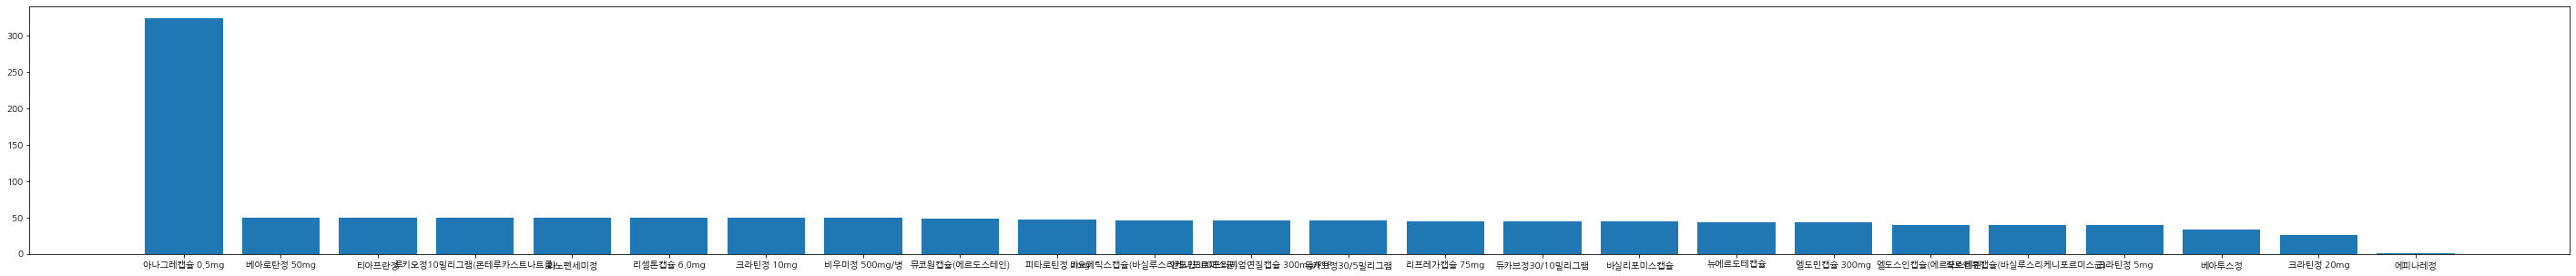

In [8]:
# 전처리 전
# 특정 약품의 데이터가 너무 많아 제거시킴
cnt = pill.value_counts()
plt.rc('font', family="NanumGothic")
plt.figure(figsize=(50, 5))
plt.bar(cnt.index, cnt.values)
plt.show()

In [ ]:
# 데이터 전처리
idx = df[df.dl_name == '아나그레캡슐 0.5mg'].index.values
random.shuffle(idx)
df.drop(idx[:270], inplace=True)

In [ ]:
cnt = df[df.dl_name=='아나그레캡슐 0.5mg']
len(cnt)

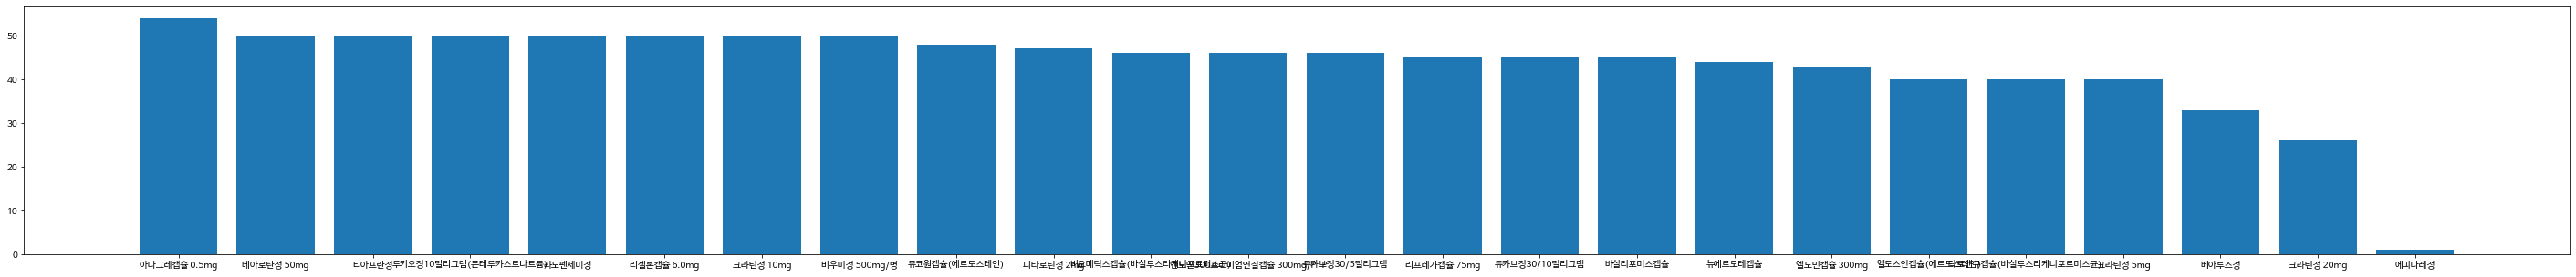

In [11]:
# 전처리 후
pill2 = df['dl_name']
cnt = pill2.value_counts()
plt.rc('font', family="NanumBarunGothic")
plt.figure(figsize=(50, 5))
plt.bar(cnt.index, cnt.values)
plt.show()

In [17]:
X_pics = [Image.open(img_name).convert("RGB") for img_name in df["file_name"]]

In [18]:
#이미지를 배열로 변환
X = [ cv2.resize(np.array(i),(64, 64)) for i in X_pics]

In [19]:
# minmax 스케일링(정규화)  generator 미사용 시 사용
X = [i/255.0 for i in X]
X = np.array(X)

In [ ]:
# 원 핫 인코딩
ohe = OneHotEncoder(sparse=False)
df_ohe = pd.DataFrame(df[['dl_name']])
y = ohe.fit(df_ohe)
y = ohe.transform(df[['dl_name']])
y

In [21]:
#Keras CNN
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [25]:
# 원본데이터로 train, test를 분류하고  train데이터로 train, validation을 분류함

# train - 학습데이터(검증데이터 포함)  test- 테스트데이터
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

# train - 최종 학습데이터, val - 검증데이터
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# imageGenerator 사용시 on
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_val = np.array(X_val)
# y_val = np.array(y_val)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

In [82]:
# ImageDataGenerator
tr_gen = ImageDataGenerator(
                            horizontal_flip=True,
                            vertical_flip=True,
                            rescale=1/255.0,
                            rotation_range=0.4,
                            zoom_range=[1.0,1.4]
                            )
val_gen = ImageDataGenerator(rescale=1/255.0)
test_gen = ImageDataGenerator(rescale=1/255.0)

flow_tr = tr_gen.flow(X_train, y_train, batch_size=16)
flow_val = val_gen.flow(X_val, y_val, batch_size=16)
flow_test = test_gen.flow(X_test, y_test, batch_size=16)

In [26]:
# resnet
def train():

    model = Sequential()

    # convolution
    model.add(Convolution2D(128,3,3, input_shape=(64,64,3)))
    model.add(Activation("relu"))
    model.add(Convolution2D(128,3,3,padding="SAME"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding="SAME"))
    
    # convolution
    model.add(Convolution2D(64,3,3, activation="relu"))
    model.add(Activation("relu"))
    model.add(Convolution2D(64,3,3,padding="SAME" ))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding="SAME"))

    model.add(Flatten())

    # NN
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(24, activation="softmax"))
    
    model.compile(optimizer="Adam", loss="categorical_crossentropy",metrics=["accuracy"])
    model.summary()
    return model

In [27]:
model = train()
# ImageDataGenerator 사용 off
history1 = model.fit(X_train,y_train,verbose=True,validation_data=(X_val, y_val),epochs=200,callbacks=[])

# ImageDataGenerator 사용 on
# history1 = model.fit(flow_tr,verbose=True,validation_data=flow_val,steps_per_epoch=16,epochs=200)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 21, 21, 128)       3584      
                                                                 
 activation_4 (Activation)   (None, 21, 21, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 activation_5 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 64)          73792     
                                                      

7/7 [==============================] - 0s 16ms/step - loss: 0.3272 - accuracy: 0.9183


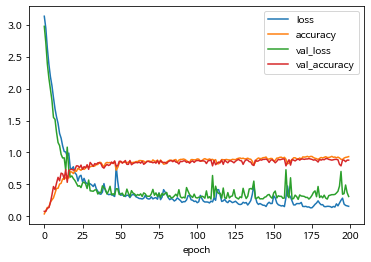

In [28]:
# generator on
# locc,acc = model.evaluate(flow_test)
# generator off
locc,acc = model.evaluate(X_test, y_test)

plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')

plt.xlabel('epoch')
plt.legend()
plt.show()

# 1차 시도에 비해 에폭수를 많이 늘렸더니 성능이 향상됨

In [30]:
predict = model.predict(X_test)

7/7 [==============================] - 1s 42ms/step


In [ ]:
# 예측 결과를 텍스트로 출력 (길어서 생략함)
predict_list = []
for i in predict:
  idx = max(i)
  predict_list.append(list(i).index(idx))
per = 0
for index, i in enumerate(predict_list):
  print(f'X_test {index+1} 번째 이미지의 예측은 {target_pill[i]}입니다. 예측확률은 {max(predict[index])*100:.2f}%입니다.')
  per += max(predict[index])*100

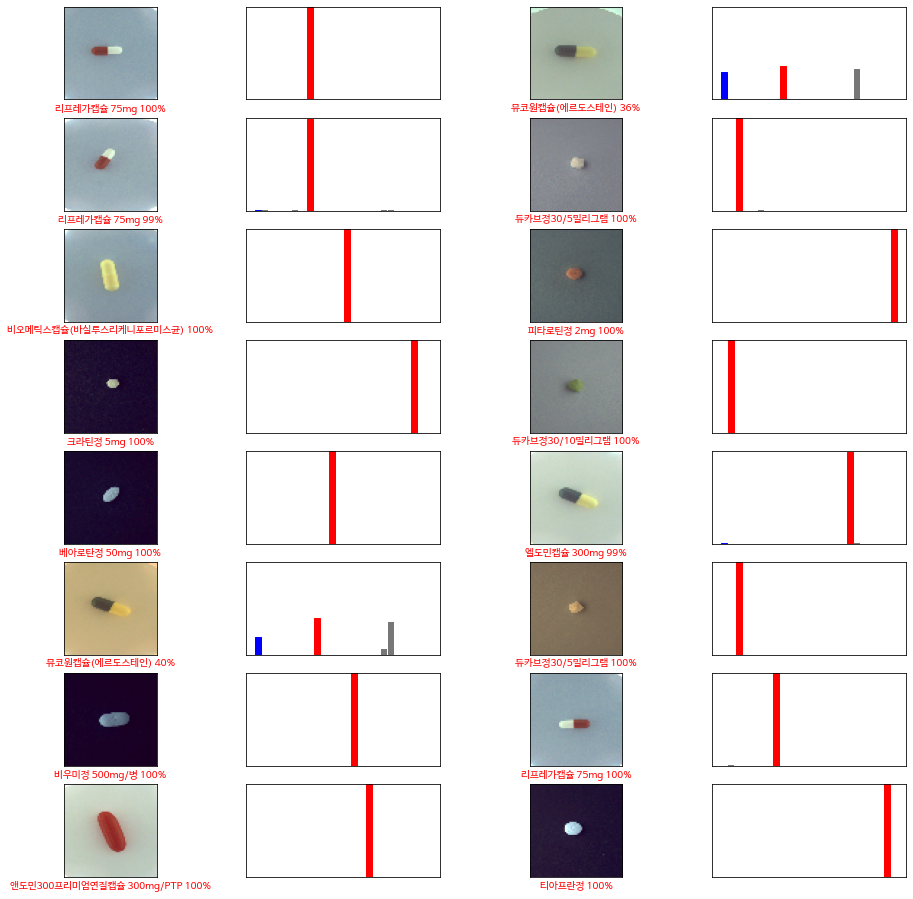

In [32]:
# 예측 결과의 일부를 그래프로 출력
def plot_image(i, predict_list, label, img):
  predict_list, label, img = predict_list[i], label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predict_label = np.argmax(predict_list)
  if predict_label == np.argmax(label):
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel(f'{target_pill[predict_label]} {100 * np.max(predict_list):2.0f}%',color=color)

def plot_value_array(i, predict_list, label):
  predict_list, label = predict_list[i], label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  now = plt.bar(range(24), predict_list, color = "#777777")
  plt.ylim([0,1])
  predict_label = np.argmax(predict_list)
  now[predict_label].set_color('red')
  now[np.argmax(label)].set_color('blue')


row = 8
col = 2
images = row * col
plt.figure(figsize=(8*col, 2*row))
plt.rc('font', family="NanumBarunGothic")
for i in range(images):
  plt.subplot(row, 2*col, 2*i+1)
  plot_image(i,predict, target_pill ,X_test)
  plt.subplot(row, 2*col, 2*i+2)
  plot_value_array(i, predict, target_pill)


#결론
상황상 적은 데이터를 사용해보았지만 모델 평가 결과 91% 정도의 예측 확률을 보여주었다. (epoch수 증가를 통해 결과를 향상 시킴)  

실 데이터가 적어 ImageDataGenerator를 사용하여 이미지 수를 증강해서 학습을 시켜보았는데 모델 평가가 오히려 60%중반까지 결과가 떨어지는 것을 보았었다. 어떠한 이유에서 그런 지는 잘 모르겠다. 이러한 이유는 조금 더 찾아봐야 할 숙제로 남는다. 그리고 ImageDataGenerator를 사용했을 때 모델(ResNet)도 그대로 사용했었는데 조금 더 tuning하여 성능이 얼마나 나오는 지 관찰해야 할 것 같다.   

2023-1-12 추가  
추가적으로 생각을 해보았지만, 어떻게 하면 성능을 높일 수 있을 지 잘 떠오르지 않았다. 단, 한가지 방법이 있다면 프로그램 상으로 데이터를 증강시키는 것이 아니라 실제 원본 데이터를 추가시켜 학습하는 방법이 있을 것 같다. 하지만 이 방법은 내 컴퓨터 상황 상 당장은 불가능한 작업(용량문제)이기 때문에 추후에 해봐야 될 것이라 생각한다.
 